In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath('thinker/thinker')
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
from thinker.buffer import ModelBuffer
from thinker.gym.asyn_vector_env import AsyncVectorEnv
import thinker.util as util
import gym
import gym_csokoban


def gplot(x, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    if type(x) == np.ndarray: x = torch.tensor(x)        
    ax.imshow(torch.swapaxes(torch.swapaxes(x.cpu(),0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)

class TransposeWrap(gym.ObservationWrapper):
    """Image shape to channels x weight x height"""
    
    def __init__(self, env):
        super(TransposeWrap, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(old_shape[-1], old_shape[0], old_shape[1]),
            dtype=np.uint8,
        )

    def observation(self, observation):
        return np.transpose(observation, axes=(2, 0, 1))    

class Node:
    def __init__(self, parent, action, logit, num_actions, discounting, rec_t):        
        
        self.action = F.one_hot(torch.tensor(action).long(), num_actions) # shape (1, num_actions)        
        self.r = torch.tensor([0.], dtype=torch.float32)    
        self.v = torch.tensor([0.], dtype=torch.float32)            
        self.logit = logit # shape (1,)        
        
        self.rollout_qs = []  # list of tensors of shape (1,)
        self.rollout_n = torch.tensor([0.], dtype=torch.float32)    
        self.parent = parent
        self.children = []
        self.encoded = None 
        
        self.num_actions = num_actions
        self.discounting = discounting
        self.rec_t = rec_t        
        
        self.visited = False

    def expanded(self):
        return len(self.children) > 0

    def expand(self, r, v, logits, encoded, override=False):
        """
        First time arriving a node and so we expand it
        r, v: tensor of shape (1,)
        logits: tensor of shape (num_actions,)
        """
        if not override: assert not self.expanded()
        if override:
            self.rollout_qs = [x - self.r + r for x in self.rollout_qs]
            self.rollout_qs[0] = v * self.discounting
        self.r = r
        self.v = v
        self.encoded = encoded
        for a in range(self.num_actions):
            if not override:
                child = self.children.append(Node(self, a, logits[[a]], 
                   self.num_actions, self.discounting, self.rec_t))
            else:
                self.children[a].logit = logits[[a]]        
            
    def visit(self):
        self.trail_r = torch.tensor([0.], dtype=torch.float32)    
        self.trail_discount = 1.
        self.propagate(self.r, self.v, not self.visited)        
        self.visited = True
        
    def propagate(self, r, v, new_rollout):
        self.trail_r = self.trail_r + self.trail_discount * r
        self.trail_discount = self.trail_discount * self.discounting
        self.rollout_q = self.trail_r + self.trail_discount * v
        if new_rollout:
            self.rollout_qs.append(self.rollout_q)
            self.rollout_n = self.rollout_n + 1
        if self.parent is not None: self.parent.propagate(r, v, new_rollout)
            
    def stat(self, detailed=False):
        assert self.expanded()
        self.child_logits = torch.concat([x.logit for x in self.children])        
        child_rollout_qs_mean = []
        child_rollout_qs_max = []
        for x in self.children:
            if len(x.rollout_qs) > 0:                
                q_mean = torch.mean(torch.cat(x.rollout_qs), dim=-1, keepdim=True)
                q_max = torch.max(torch.cat(x.rollout_qs), dim=-1, keepdim=True)[0]
            else:
                q_mean = torch.tensor([0.], dtype=torch.float32)    
                q_max = torch.tensor([0.], dtype=torch.float32)    
            child_rollout_qs_mean.append(q_mean)
            child_rollout_qs_max.append(q_max)
        self.child_rollout_qs_mean = torch.concat(child_rollout_qs_mean)
        self.child_rollout_qs_max = torch.concat(child_rollout_qs_max)

        if detailed:
            self.trail_r_undiscount = self.trail_r / self.discounting
            self.rollout_q_undiscount = self.rollout_q / self.discounting
            self.max_q = torch.max(torch.concat(self.rollout_qs) - self.r).unsqueeze(-1) / self.discounting            
        
        self.child_rollout_ns = torch.tensor([x.rollout_n for x in self.children]).long()
        self.child_rollout_ns_enc = self.child_rollout_ns / self.rec_t       
            
        ret_list = ["action", "r", "v", "child_logits", "child_rollout_qs_mean",
                    "child_rollout_qs_max", "child_rollout_ns_enc"]
        if detailed: ret_list.extend(["trail_r_undiscount", "rollout_q_undiscount", "max_q"])
        self.ret_dict = {x: getattr(self, x) for x in ret_list}
        #for x in ret_list: print(x, getattr(self, x))
        out = torch.concat(list(self.ret_dict.values()))        
        return out         

class ModelWrapper(gym.Wrapper):
    """Wrap the gym environment with a model; output for each 
    step is (out, reward, done, info), where out is a tuple 
    of (gym_env_out, model_out) that corresponds to underlying 
    environment frame and output from the model wrapper.
    """

    def __init__(self, env, flags, env_n):
        gym.Wrapper.__init__(self, env)
        
        self.env = env     
        self.rec_t = flags.rec_t        
        self.flex_t = flags.flex_t 
        self.flex_t_cost = flags.flex_t_cost         
        self.discounting = flags.discounting
        self.perfect_model = flags.perfect_model
        self.tree_carry = flags.tree_carry
        self.thres_carry = flags.thres_carry        
        self.thres_discounting = flags.thres_discounting
        self.num_actions = env.action_space[0].n
        self.env_n = env_n
            
        if not self.flex_t:
            obs_n = 9 + self.num_actions * 10 + self.rec_t
        else:
            obs_n = 10 + self.num_actions * 11 
        
        self.observation_space = gym.spaces.Box(
          low=-np.inf, high=np.inf, shape=(env_n, obs_n, 1, 1), dtype=float)
        
    def reset(self, model_net):
        with torch.no_grad():
            # some init.
            self.root_max_q = [None for _ in range(self.env_n)]
            self.rollout_depth = torch.zeros(self.env_n, dtype=int)
            self.max_rollout_depth = torch.zeros(self.env_n, dtype=int)
            self.cur_t = torch.zeros(self.env_n, dtype=int)

            # reset obs
            obs = self.env.reset()

            # obtain output from model
            obs_py = torch.tensor(obs, dtype=torch.uint8)
            pass_action = [0 for _ in range(self.env_n)] 
            _, vs, logits, encodeds = model_net(obs_py, 
                                                torch.tensor(pass_action, dtype=torch.long).unsqueeze(0), 
                                                one_hot=False)  

            self._debug = (obs_py, pass_action, logits, obs)
            encodeds = self.env.clone_state(inds=np.arange(self.env_n))

            # compute and update root node and current node
            self.root_nodes = []
            self.cur_nodes = []
            for n in range(self.env_n):
                root_node = Node(parent=None, action=pass_action[n], logit=None, 
                num_actions=self.num_actions, discounting=self.discounting, rec_t=self.rec_t)
                encoded = {"env_state": encodeds[n], "gym_env_out": obs_py[n]}
                root_node.expand(r=torch.tensor([0.], dtype=torch.float32), 
                                 v=vs[-1, n].unsqueeze(-1), 
                                 logits=logits[-1, n],
                                 encoded=encoded)
                root_node.visit()
                self.root_nodes.append(root_node)
                self.cur_nodes.append(root_node)
            
            model_out = self.compute_model_out(None, None)
            gym_env_out = torch.concat([x.encoded["gym_env_out"].unsqueeze(0) for x in self.cur_nodes])
            return (model_out, gym_env_out), None


    def step(self, action, model_net, model_state=None):  
        # action is in shape (1, env_n, 3) or (1, env_n, 4); 
        # which corresponds to real_action, im_action, reset, term

        assert self.perfect_model, "imperfect model not yet supported"
        with torch.no_grad():
            if not self.flex_t:
                re_action, im_action, reset = action[:, 0], action[:, 1], action[:, 2]
                term = None
            else:
                re_action, im_action, reset, term = (action[:, 0], action[:, 1], 
                    action[:, 2], action[:, 3])
            info = {}
            info["max_rollout_depth"] = self.max_rollout_depth

            # compute the mask of real / imagination step
            if not self.flex_t:
                imagine_b = self.cur_t < self.rec_t - 1
            else:
                imagine_b = (self.cur_t < self.rec_t - 1) & ~term
            
            self.cur_t += 1
            self.cur_t[~imagine_b] = 0
            self.rollout_depth += 1
            self.rollout_depth[~imagine_b] = 0        
            self.max_rollout_depth[~imagine_b] = 0
            self.max_rollout_depth = torch.max(self.max_rollout_depth, self.rollout_depth)

            # four status: 
            # 1. real transition; 
            # 2. imaginary transition and expanded
            # 3. imaginary transition and done and unexpanded; 
            # 4. imagainary transition and not done and unexpanded
            # compute the status here
            
            status = torch.zeros(self.env_n, dtype=torch.long)
            status[~imagine_b] = 1             

            if torch.any(imagine_b):
                sl_cur_nodes = [x for n, x in enumerate(self.cur_nodes) if imagine_b[n]]
                sl_next_nodes = [x.children[im_action[n]] for n, x in enumerate(self.cur_nodes) if imagine_b[n]]            
                status[imagine_b] = torch.tensor([2 if y.expanded() else (3 if 'done' in x.encoded else 4) for x, y in zip(sl_cur_nodes, sl_next_nodes)])
            self._status = status
            
            # use the model; only status 1 and 4 need to use env and model
            if torch.any((status == 1) | (status == 4)):
                sel_inds = torch.arange(self.env_n)[(status == 1) | (status == 4)]
                pass_env_states = [self.root_nodes[n].encoded["env_state"] if s == 1 else 
                    self.cur_nodes[n].encoded["env_state"] for n, s in enumerate(status) if s in [1, 4]]  
                self.env.restore_state(pass_env_states, inds=sel_inds)
                pass_action = torch.tensor([re_action[n] if s == 1 else 
                    im_action[n] for n, s in enumerate(status) if s in [1, 4]], dtype=torch.long)
                obs, reward, done, info = self.env.step(pass_action, inds=sel_inds) 

                # reset if done and the transition is real
                reset_needed = torch.zeros(self.env_n, dtype=torch.bool)
                reset_needed[sel_inds] = torch.tensor(done)
                reset_needed = reset_needed & (status == 1)
                if torch.any(reset_needed):
                    reset_inds = torch.arange(self.env_n)[reset_needed]
                    obs = self.env.reset(inds=reset_inds)
                    pass_action[reset_needed[sel_inds]] = 0

                obs_py = torch.tensor(obs, dtype=torch.uint8)
                _, vs, logits, encodeds = model_net(obs_py, 
                                                    pass_action.unsqueeze(0), 
                                                    one_hot=False)  
                encodeds = self.env.clone_state(inds=sel_inds)                   

            m_ind = 0
            root_nodes, cur_nodes = [], []

            # compute the current and root nodes
            for n in range(self.env_n):
                if status[n] == 1:
                    # real transition
                    new_root = (not self.tree_carry or 
                        not self.root_nodes[n].children[re_action[n]].expanded() or done[m_ind])
                    if new_root:
                        root_node = Node(parent=None, action=pass_action[m_ind].item(), logit=None, 
                        num_actions=self.num_actions, discounting=self.discounting, rec_t=self.rec_t)
                        encoded = {"env_state": encodeds[m_ind], "gym_env_out": obs_py[m_ind]}
                        root_node.expand(r=torch.tensor([0.], dtype=torch.float32), 
                                        v=vs[-1, m_ind].unsqueeze(-1), 
                                        logits=logits[-1, m_ind],
                                        encoded=encoded)
                        root_node.visit()
                    else:
                        root_node = self.root_nodes[n].children[re_action[n]]
                        encoded = {"env_state": encodeds[m_ind], "gym_env_out": obs_py[m_ind]}
                        root_node.expand(r=torch.tensor([0.], dtype=torch.float32), 
                                            v=vs[-1, m_ind].unsqueeze(-1), 
                                            logits=logits[-1, m_ind],
                                            encoded=encoded, 
                                            override=True)
                        root_node.parent = None
                        root_node.visit()
                    
                    root_nodes.append(root_node)
                    cur_nodes.append(root_node)
                    m_ind += 1
                
                elif status[n] == 2:
                    cur_node = self.cur_nodes[n].children[im_action[n]]
                    cur_node.visit()
                    root_nodes.append(self.root_nodes[n])
                    cur_nodes.append(cur_node)                    

                elif status[n] == 3:
                    logits = torch.concat([ch.logit for ch in self.cur_nodes[n].children])  
                    cur_node = self.cur_nodes[n].children[im_action[n]]
                    cur_node.expand(r=torch.tensor([0.], dtype=torch.float32), 
                                    v=torch.tensor([0.], dtype=torch.float32),
                                    logits=logits, 
                                    encoded=self.cur_nodes[n].encoded) 
                    cur_node.visit()
                    root_nodes.append(self.root_nodes[n])
                    cur_nodes.append(cur_node)
                    
                elif status[n] == 4:
                    encoded = {"env_state": encodeds[m_ind], "gym_env_out": obs_py[m_ind]}
                    if done[m_ind]: encoded["done"] = True
                    cur_node = self.cur_nodes[n].children[im_action[n]]
                    cur_node.expand(r=torch.tensor([reward[m_ind]], dtype=torch.float32), 
                                    v=vs[-1, m_ind].unsqueeze(0) if not done[m_ind] else torch.zeros(1, dtype=torch.float32),
                                    logits=logits[-1, m_ind], 
                                    encoded=encoded) 
                    cur_node.visit()
                    root_nodes.append(self.root_nodes[n])
                    cur_nodes.append(cur_node)
                    
                    m_ind += 1

            self.root_nodes = root_nodes
            self.cur_nodes = cur_nodes

        model_out = self.compute_model_out(action, imagine_b)
        gym_env_out = torch.concat([x.encoded["gym_env_out"].unsqueeze(0) for x in self.cur_nodes])

        self.compute_reset(reset)

        return (model_out, gym_env_out), None


    def compute_model_out(self, action, imagine_b):
        nodes_stat = []
        for n in range(self.env_n):
            root_node_stat = self.root_nodes[n].stat(detailed=True)
            cur_node_stat = self.cur_nodes[n].stat()                        
            nodes_stat.append(torch.concat([root_node_stat, cur_node_stat]).unsqueeze(0))
        nodes_stat = torch.concat(nodes_stat)
        if action is None: 
            reset = torch.ones(self.env_n, 1, dtype=torch.float32)    
        else:
            reset = action[:, 2].unsqueeze(1)
            reset[~imagine_b] = 1.
        depc = (self.discounting ** (self.rollout_depth-1)).unsqueeze(-1)
        if not self.flex_t:
            time = F.one_hot(self.cur_t, self.rec_t).float()
        else:
            time = (self.discounting ** (self.cur_t)).unsqueeze(-1)
        
        if not self.flex_t:
            ret_list = [nodes_stat, reset, time, depc]
        else:
            if action is None: 
                term = torch.zeros(self.env_n, 1, dtype=torch.float32)    
            else:
                term = action[:, 3].unsqueeze(1)                          
            ret_list = [nodes_stat, reset, term, time, depc]
        model_out = torch.concat(ret_list, dim=-1)  
        return model_out

    def compute_reset(self, reset):
        reset_b = (reset == 1)
        self.rollout_depth[reset_b] = 0
        for n in torch.arange(self.env_n)[reset_b]:
            self.cur_nodes[n] = self.root_nodes[n]
            self.cur_nodes[n].visit()


def align(model_out):
    num_actions = 5
    new_model_out = torch.clone(model_out)
    new_model_out[-3:] = model_out[5*num_actions+2:5*num_actions+2+3]
    new_model_out[5*num_actions+2:-3] = model_out[5*num_actions+2+3:]
    return new_model_out

    
flags = util.parse([])
flags.rec_t = 5

model_net = ModelNet((3,80,80), 5, flags)
_ = model_net.train(False)

In [2]:
import thinker.env
torch.set_printoptions(precision=5)
env_n = 2

env = AsyncVectorEnv([lambda: TransposeWrap((gym.make("cSokoban-v0"))) for _ in range(env_n)])
env.seed([0,0])
env = ModelWrapper(env, flags, env_n)
(model_out, gym_env_out), _ = env.reset(model_net)

env_ = TransposeWrap((gym.make("cSokoban-v0")))
env_.seed(0)
env_ = thinker.env.ModelWrapper(env_, flags)
(gym_env_out_, model_out_), _ = env_.reset(model_net)

print("initial diff ", torch.sum(torch.square(model_out_-align(model_out[0]))))


for n in range(100000):
    action = torch.tensor([[np.random.randint(5),np.random.randint(5),np.random.randint(1)],
     [np.random.randint(5),np.random.randint(5),np.random.randint(1)]])
    (model_out, gym_env_out), _ = env.step(action, model_net)
    (gym_env_out_, model_out_), reward_, done_, info_, _ = env_.step(action[1].numpy(), model_net, None)
    if done_: (gym_env_out_, model_out_), _ = env_.reset(model_net)
    diff = torch.sum(torch.square(model_out_-align(model_out[1])))
    diff_env = torch.sum(torch.square(torch.tensor(gym_env_out_) - gym_env_out[1]))
    if diff > 0.00001 or diff_env > 1:
        raise Exception("%d unmatched output; diff: %.6f %.6f" % (n, diff, diff_env))

initial diff  tensor(1.31839e-16)


KeyboardInterrupt: 

In [487]:
torch.set_printoptions(precision=5, sci_mode=False)
print(align(model_out[0]))
print(model_out_)

tensor([     0.00000,      0.00000,      0.00000,      0.00000,      1.00000,
             0.00000,     -0.00407,     -0.00052,     -0.00713,      0.02097,
            -0.01264,      0.02014,      0.00000,     -0.02690,      0.00000,
             0.00000,      0.00000,      0.00000,     -0.01223,      0.00000,
             0.00000,      0.00000,      0.00000,      0.80000,      0.00000,
             0.00000,      0.00000,      0.00000,      0.00000,      1.00000,
             0.00000,      0.00000,     -0.01000,      0.00000,      0.00072,
            -0.00795,      0.02057,     -0.01337,      0.02109,      0.00000,
             0.00000,      0.00000,      0.00000,      0.00000,      0.00000,
             0.00000,      0.00000,      0.00000,      0.00000,      0.00000,
             0.00000,      0.00000,      0.00000,      0.00000,      0.00000,
             0.00000,      0.00000,      0.00000,      0.00000,      1.00000,
             0.91267,     -0.03824,     -0.03824,     -0.00407])

In [264]:
print(torch.sum((env._debug[0].float() - env._debug[0].float()) ** 2))
print(env._debug[2])
print(env_._debug[2])

tensor(0.)
tensor([[[-0.0247, -0.0427, -0.0251, -0.0217, -0.0294]]])
tensor([[[-0.0239, -0.0415, -0.0255, -0.0215, -0.0288]]])


In [273]:
m = 3
print(env._debug[m].shape, env._debug[m].dtype)
print(env_._debug[m].shape, env._debug[m].dtype)
print(torch.sum((env._debug[m] - env_._debug[m])**2))

(1, 3, 80, 80) uint8
(3, 80, 80) uint8


TypeError: sum(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

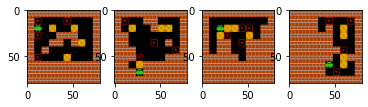

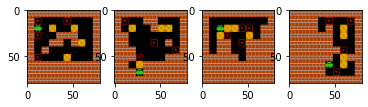

In [ ]:
env_n = 4
flags = util.parse([])

env = gym.vector.make(flags.env, num_envs=env_n)
env.seed([i for i in range(env_n)])




actions = np.array([1, 0, 1, 2])

obs = env.reset()
fig, axes = plt.subplots(1,4)
for i in range(4):
    axes[i].imshow(obs[i])

fig, axes = plt.subplots(1,4)
for i in range(4):
    axes[i].imshow(obs[i])

In [ ]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.actor_see_p = 0
flags.actor_drc = True
flags.rec_t = 5

env = Environment(flags)
model_net = ModelNet((3,80,80), 5, flags)
env_out, model_state = env.initial(model_net)
actor_net = ActorNet(env.model_out_shape, 5, flags)

nc = actor_net
print("actor network size: ", sum(p.numel() for p in nc.parameters()))
nc = model_net
print("model network size: ", sum(p.numel() for p in nc.parameters()))

a = torch.tensor([1,1,1]).long().unsqueeze(0).unsqueeze(0)
actor_state = actor_net.initial_state(1)

for n in range(5):
   env_out, model_state = env.step(a, model_net, model_state)
   actor_out, actor_state = actor_net(env_out, actor_state)

actor network size:  660158
model network size:  2352882


AttributeError: 'SokobanEnv' object has no attribute 'baseline_max_q'

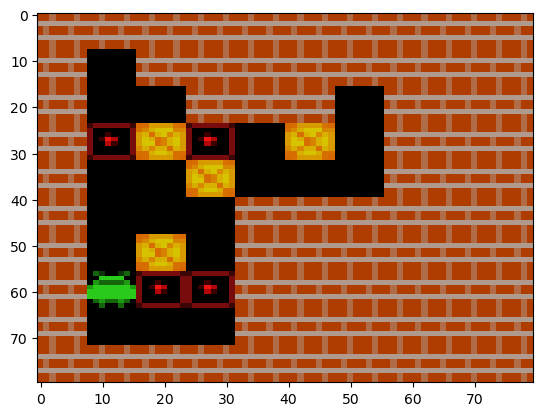

In [ ]:
a = torch.tensor([4,2,0]).long().unsqueeze(0).unsqueeze(0)
env_out, model_state = env.step(a, model_net, model_state)
cur_t = env_out.cur_t
x = env_out.gym_env_out[0]
plot_gym_env_out(x)
print(env_out.cur_t, env_out.see_mask, env.env.baseline_max_q)
device = torch.device("cuda")
actor_net.to(device)
actor_state = util.tuple_map(actor_state, lambda x: x.to(device))
env_out = util.tuple_map(env_out, lambda x: x.to(device))

out, actor_state = actor_net(env_out, actor_state)
print([x.dtype for x in out[0] if x is not None])


In [ ]:
k = 3
t = 4
n = 1
next_ind = np.array([3, np.nan, np.nan])

base_ind = 2 * n
base_ind_pri = t * base_ind

abs_flat_inds = np.array([6 + base_ind_pri, 5 + base_ind_pri])

# compute the correct index to update; if the indexes are across blocks,
# we have to carry the overflowing index to the next block

flat_inds = abs_flat_inds - base_ind_pri # get the relative index
mask = flat_inds > 0 
flat_inds = flat_inds[mask] 

flat_inds = flat_inds[:, np.newaxis] + np.arange(k) # flat_inds now stores uncarried indexes
flat_inds_block = flat_inds // (t * n) # block index of flat_inds
carry_mask = ~(flat_inds_block[:,[0]] == flat_inds_block).reshape(-1) 
# if first index block is not the same as the later index block, we need to carry it

flat_inds = flat_inds.reshape(-1)
flat_inds_block = flat_inds_block.reshape(-1)
carry_inds_block = next_ind[flat_inds_block[carry_mask]-1] - base_ind // n  # the correct index block

flat_inds = flat_inds.astype(float)
flat_inds[carry_mask] = flat_inds[carry_mask] + (-flat_inds_block[carry_mask] + carry_inds_block) * (t * n) 
mask = ~np.isnan(flat_inds)
flat_inds = flat_inds[mask].astype(int)
print(flat_inds_block)
print(carry_mask)
print(carry_inds_block)
print(flat_inds)

[1 1 2 1 1 1]
[False False  True False False False]
[nan]
[6 7 5 6 7]


In [ ]:

flags = util.parse([])
flags.model_batch_size = 2
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = False
flags.model_rnn = True
flags.model_unroll_length = 8
t = flags.model_unroll_length   
flags.model_k_step_return = 5
k = flags.model_k_step_return
flags.actor_parallel_n = 1
n = flags.actor_parallel_n  

flags.model_batch_mode = True

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),c), torch.full((t+k, n, 1),c+0.1))    
    state = (torch.full((n, 3),c+0.2), torch.full((n, 3),c+0.3))
    model_buffer.write(data, state, np.random.randint(10))

print(model_buffer.next_inds)
data, data_state, weights, abs_flat_inds, inds = model_buffer.read(1)
print(data.x[:, :, -1], data_state)

state = tuple(torch.zeros_like(x) for x in data_state)
priorities = torch.zeros(len(abs_flat_inds))

model_buffer.update_priority(abs_flat_inds, priorities, state)



In [ ]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.model_rnn = True

model_net_1 = ModelNet((3,80,80), 5, flags)
nc = model_net_1
print("network size: ", sum(p.numel() for p in nc.parameters()))

flags.model_rnn = False
model_net_2 = ModelNet((3,80,80), 5, flags)
nc = model_net_2
print("network size: ", sum(p.numel() for p in nc.parameters()))

network size:  841223
network size:  2352882


In [ ]:
tran = {"conv1":  "output_rvpi.conv1",
        "conv2":  "output_rvpi.conv2",
        "policy": "output_rvpi.fc_logits",
        "baseline": "output_rvpi.fc_v",
        "r": "output_rvpi.fc_r",
        "frame_conv.0":  "output_rvpi.conv1",
        "frame_conv.2":  "output_rvpi.conv2",}

state_dict = {}
for k in model_net_1.state_dict().keys():
    #print(k)
    if k not in model_net_2.state_dict().keys():
        for p, q in tran.items():
            if k[:len(p)+1] == p+".":
                out = q + k[len(p):]
                break
    else:
        out = k
    state_dict[k] = model_net_2.state_dict()[out]

model_net_1.load_state_dict(state_dict)
model_net_1.train(False)
model_net_2.train(False)

x = torch.rand(4, 3, 80, 80) * 2555
actions = torch.zeros(1, 4, dtype=torch.long)
done = torch.zeros(1, 4, dtype=torch.bool)

state = model_net_1.init_state(4)
vs, logits, states = model_net_1(x=x.unsqueeze(0), actions=actions, done=done, state=state)
print(logits)

rs, vs, logits, encodeds = model_net_2(x=x, actions=actions)
print(logits)

tensor([[[ 0.0005,  0.0253,  0.0640,  0.0987, -0.0419],
         [ 0.0010,  0.0284,  0.0646,  0.0968, -0.0359],
         [ 0.0019,  0.0287,  0.0614,  0.0948, -0.0363],
         [ 0.0028,  0.0284,  0.0636,  0.0960, -0.0396]]],
       grad_fn=<ViewBackward0>)
tensor([[[ 0.0005,  0.0253,  0.0640,  0.0987, -0.0419],
         [ 0.0010,  0.0284,  0.0646,  0.0968, -0.0359],
         [ 0.0019,  0.0287,  0.0614,  0.0948, -0.0363],
         [ 0.0028,  0.0284,  0.0636,  0.0960, -0.0396]]],
       grad_fn=<CatBackward0>)
